# Team _Flight to Abu Dhabi_
## SC Quantath0n v1

### Getting started

We'll start by installing the required packages

In [1]:
%pip install pennylane jax optax aiohttp fsspec h5py numpy

Note: you may need to restart the kernel to use updated packages.


### VQE Implementation

The **Variational Quamntum Eigensolver** algorithm can be used to find the energy of the ground state.  We present a basic implemntation:

In [ ]:
import pennylane as qml
from pennylane import qchem
from pennylane import numpy as np

symbals = ['H','H']
geometry = np.array([[0,0,-0.6614],[0,0,0.6614]])

dataset = qml.data.load('qchem', molname="H2")[0]
H, qubits = dataset.hamiltonian, len(dataset.hamiltonian.wires)
print("Number of qubits = ", qubits)
#print("The Hamiltonian is ", H)
electrons = 2

# Generate single and double excitations
singles, doubles = qml.qchem.excitations(electrons, qubits)


# Map excitations to the wires the UCCSD circuit will act on
s_wires, d_wires = qml.qchem.excitations_to_wires(singles, doubles)

hf = qml.qchem.hf_state(electrons, qubits) #this will give you the hf state when given the number of electrons and number of qubits
print(hf)

ModuleNotFoundError: No module named 'pennylane'

In [ ]:
#define the device
dev = qml.device("lightning.qubit", wires=qubits)


def circuit(params, wires, s_wires, d_wires, hf):
    qml.UCCSD(params, wires, s_wires, d_wires, hf)
    #return qml.expval(H)

params = np.zeros(len(singles) + len(doubles))

@qml.qnode(dev)
def cost_fn(params):
    circuit(params, wires=range(qubits), s_wires=s_wires, d_wires=d_wires, hf = hf)
    return qml.expval(H)

initial_energy = cost_fn(params)
print("initial energy: ", initial_energy)

# Perform VQE optimization to find the ground state energy
max_iterations = 1000
opt = qml.SPSAOptimizer(maxiter=max_iterations)

for i in range(max_iterations):
    params, energy = opt.step_and_cost(cost_fn, params)
print(energy)

initial energy:  -1.1166511627456919
-1.137262809292572


In [ ]:
%pip install aiohttp fsspec h5py

In [ ]:
import pennylane as qml
from pennylane import qchem
import numpy as np
import pandas as pd

# Define the molecule's bond length and compute molecular Hamiltonian
bondlength = 0.742  # in angstroms

# Create the symbols and coordinates for the molecule (without multiplicity)
symbols = ["H", "H"]
coordinates = np.array([[0.0, 0.0, 0.0], [0.0, 0.0, bondlength]])  # Cartesian coordinates in angstroms

# Generate the molecular Hamiltonian using the symbols, coordinates, charge
H, qubits = qchem.molecular_hamiltonian(
    symbols=symbols,
    coordinates=coordinates,
    charge=0,
    basis="STO-3G"
)

# Print the Hamiltonian in a readable form
print("Hamiltonian terms (coefficients and operators):")
for term in H.terms():
    print(term)

# Print the number of qubits required
print(f"Number of qubits: {qubits}")

# Assuming H contains some useful data, place it into a DataFrame (if needed)
# For now, we will store just a simple representation of the Hamiltonian
hamiltonian_data = {"Hamiltonian": [str(H)], "Qubits": [qubits]}
df = pd.DataFrame(hamiltonian_data)

# Print the DataFrame to inspect
# print(df)
df.head()

Hamiltonian terms (coefficients and operators):
[tensor(0.77359758, requires_grad=False), tensor(0.23694753, requires_grad=False), tensor(0.23694753, requires_grad=False), tensor(0.18451831, requires_grad=False), tensor(-0.4602733, requires_grad=False), tensor(0.14060027, requires_grad=False), tensor(0.18165504, requires_grad=False), tensor(0.04105477, requires_grad=False), tensor(-0.04105477, requires_grad=False), tensor(-0.04105477, requires_grad=False), tensor(0.04105477, requires_grad=False), tensor(-0.4602733, requires_grad=False), tensor(0.18165504, requires_grad=False), tensor(0.14060027, requires_grad=False), tensor(0.19173392, requires_grad=False)]
[I(), Z(0), Z(1), Z(0) @ Z(1), Z(2), Z(0) @ Z(2), Z(1) @ Z(2), Y(0) @ X(1) @ X(2) @ Y(3), Y(0) @ Y(1) @ X(2) @ X(3), X(0) @ X(1) @ Y(2) @ Y(3), X(0) @ Y(1) @ Y(2) @ X(3), Z(3), Z(0) @ Z(3), Z(1) @ Z(3), Z(2) @ Z(3)]
Number of qubits: 4


,Hamiltonian,Qubits
0,0.7735975819585176 * I(0) + 0.2369475290161028...,4


In [ ]:
import pennylane as qml
from pennylane import numpy as np

# Load the pre-generated molecular dataset for H2 from the PennyLane dataset
dataset = qml.data.load("qchem", molname="H2", bondlength=0.742, basis="STO-3G")

# Extract the Hamiltonian
H = dataset[0].hamiltonian

# Set up the quantum device
n_qubits = len(H.wires)  # Number of qubits needed for the Hamiltonian
dev = qml.device("default.qubit", wires=n_qubits)

# Define a deeper ansatz (variational circuit)
def ansatz(params, wires):
    qml.templates.StronglyEntanglingLayers(params, wires=wires)

# Cost function to minimize for the ground state
@qml.qnode(dev)
def cost_fn(params):
    ansatz(params, wires=range(n_qubits))
    return qml.expval(H)

# Get the state of the system
@qml.qnode(dev)
def get_state(params):
    ansatz(params, wires=range(n_qubits))
    return qml.state()

# VQE for Ground State
def vqe_ground_state(num_layers, max_iterations=300):
    # Randomly initialize parameters for the ansatz
    params = np.random.normal(0, np.pi, (num_layers, n_qubits, 3))

    # Optimizer
    optimizer = qml.AdamOptimizer(stepsize=0.03)  # Adjust learning rate
    conv_tol = 1e-6

    for n in range(max_iterations):
        params, cost = optimizer.step_and_cost(cost_fn, params)
        if n % 10 == 0:
            print(f"Iteration {n}: Ground state energy = {cost:.8f}")
        if np.abs(cost + 1.136376576275189) < conv_tol:  # Close to expected value
            print("Converged")
            break

    return cost, params

# Cost function to minimize for the excited state (using SSVQE method)
def excited_cost_fn(params_excited, params_ground):
    # Prepare the ground state
    ground_state = get_state(params_ground)

    # Prepare the excited state
    excited_state = get_state(params_excited)

    # Calculate the energy of the excited state
    energy = cost_fn(params_excited)

    # Penalize overlap with the ground state to enforce orthogonality
    overlap_penalty = np.abs(np.dot(ground_state.conj().T, excited_state))**2

    return energy + 5 * overlap_penalty  # Apply strong overlap penalty

# VQE for Excited State
def vqe_excited_state(params_ground, num_layers, max_iterations=300):
    # Randomly initialize parameters for the excited state ansatz
    params_excited = np.random.normal(0, np.pi, (num_layers, n_qubits, 3))

    # Optimizer
    optimizer = qml.AdamOptimizer(stepsize=0.03)  # Adjust learning rate
    conv_tol = 1e-6

    for n in range(max_iterations):
        params_excited, cost = optimizer.step_and_cost(lambda p: excited_cost_fn(p, params_ground), params_excited)
        if n % 10 == 0:
            print(f"Iteration {n}: Excited state energy = {cost:.8f}")
        if np.abs(cost + 0.53320790) < conv_tol:  # Close to expected value
            print("Converged")
            break

    return cost, params_excited

# Function to calculate the spectral gap using VQE
def calculate_spectral_gap(num_layers=8, max_iterations=300):
    # Find the ground state energy using VQE
    print("Optimizing ground state...")
    ground_energy, params_ground = vqe_ground_state(num_layers, max_iterations)

    # Find the first excited state energy using modified VQE
    print("Optimizing excited state...")
    excited_energy, params_excited = vqe_excited_state(params_ground, num_layers, max_iterations)

    # Calculate and return the spectral gap
    spectral_gap = excited_energy - ground_energy
    print(f"\nGround state energy: {ground_energy:.8f} Ha")
    print(f"First excited state energy: {excited_energy:.8f} Ha")
    print(f"Spectral gap: {spectral_gap:.8f} Ha")
    return spectral_gap

# Calculate the spectral gap
spectral_gap = calculate_spectral_gap(num_layers=8, max_iterations=300)


Optimizing ground state...
Iteration 0: Ground state energy = -0.18336426
Iteration 10: Ground state energy = -0.85696939
Iteration 20: Ground state energy = -1.07800806
Iteration 30: Ground state energy = -1.11870761
Iteration 40: Ground state energy = -1.12699393
Iteration 50: Ground state energy = -1.13587216
Iteration 60: Ground state energy = -1.13606392
Iteration 70: Ground state energy = -1.13690145
Iteration 80: Ground state energy = -1.13714001
Iteration 90: Ground state energy = -1.13721766
Iteration 100: Ground state energy = -1.13724630
Iteration 110: Ground state energy = -1.13725602
Iteration 120: Ground state energy = -1.13726132
Iteration 130: Ground state energy = -1.13726249
Iteration 140: Ground state energy = -1.13726298
Iteration 150: Ground state energy = -1.13726324
Iteration 160: Ground state energy = -1.13726329
Iteration 170: Ground state energy = -1.13726331
Iteration 180: Ground state energy = -1.13726332
Iteration 190: Ground state energy = -1.13726332
Iter

In [ ]:
import pennylane as qml
from pennylane import numpy as np

In [ ]:
# Load the pre-generated molecular dataset for H2 from the PennyLane dataset
dataset = qml.data.load("qchem", molname="H2", bondlength=0.742, basis="STO-3G")

# Print the dataset structure to understand it
print(dataset)


[<Dataset = molname: H2, basis: STO-3G, bondlength: 0.742, attributes: ['basis', 'basis_rot_groupings', ...]>]


In [ ]:
import pennylane as qml
from pennylane import numpy as np

def my_quantum_function(x, y):
    qml.RZ(x, wires=0)
    qml.CNOT(wires=[0,1])
    qml.RY(y, wires=1)
    return qml.expval(qml.PauliZ(1))

In [ ]:
dev = qml.device('default.qubit', wires=2, shots=1000)


In [ ]:
dev = qml.device('default.qubit', wires=3)

In [ ]:
dev_unique_wires = qml.device('default.qubit', wires=['aux', 'q1', 'q2'])

In [ ]:
def my_quantum_function(x, y):
    qml.RZ(x, wires='q1')
    qml.CNOT(wires=['aux' ,'q1'])
    qml.RY(y, wires='q2')
    return qml.expval(qml.PauliZ('q2'))

In [ ]:
shots_list = [5, 10, 1000]
dev = qml.device("default.qubit", wires=2, shots=shots_list)

In [ ]:
@qml.qnode(dev)
def circuit(x):
    qml.RX(x, wires=0)
    qml.CNOT(wires=[0, 1])
    return qml.expval(qml.PauliZ(0) @ qml.PauliX(1)), qml.expval(qml.PauliZ(0))

In [ ]:
results = circuit(0.5)
results

((-0.2, 1.0), (-0.2, 1.0), (-0.012, 0.868))

In [ ]:
results[0]

(-0.2, 1.0)

In [ ]:
circuit = qml.QNode(my_quantum_function, dev_unique_wires)

In [ ]:
dev = qml.device('default.qubit', wires=2)

@qml.qnode(dev)
def circuit(x):
    qml.RZ(x, wires=0)
    qml.CNOT(wires=[0,1])
    qml.RY(x, wires=1)
    return qml.expval(qml.PauliZ(1))

result = circuit(0.543)


In [ ]:
dataset = qml.data.load('qchem',molname="H2", bondlength=0.7)[0]
hamiltonian, qubits = dataset.hamiltonian, len(dataset.hamiltonian.wires)
hamiltonian_coeffs, hamiltonian_ops = hamiltonian.terms()

print("Number of qubits = ", qubits)

Number of qubits =  4


In [ ]:
dev = qml.device("default.qubit", wires=qubits)
hf_state = np.array([1, 1, 0, 0])  # Removed 'requires_grad=False'

def ansatz(params, wires=[0, 1, 2, 3]):
    qml.BasisState(hf_state, wires=wires)
    for i in wires:
        qml.RZ(params[3 * i], wires=i)
        qml.RY(params[3 * i + 1], wires=i)
        qml.RZ(params[3 * i + 2], wires=i)
    qml.CNOT(wires=[2, 3])
    qml.CNOT(wires=[2, 0])
    qml.CNOT(wires=[3, 1])


In [ ]:
@qml.qnode(dev, interface="autograd")
def cost(params):
    ansatz(params)
    return qml.expval(hamiltonian)

In [ ]:
exact_value = dataset.fci_energy # -1.1361895496530567
exact_value

-1.1361895496530567

In [10]:
np.random.seed(0)
init_params = np.random.uniform(low=0, high=2 * np.pi, size=12)  # Removed 'requires_grad=True'
max_iterations = 500
step_size = 0.5
conv_tol = 1e-06


In [11]:
import pennylane as qml
import numpy as np

# Initialize parameters (add randomness if needed)
params = qml.numpy.array(init_params, requires_grad=True)

# Set up the optimizer
opt = qml.GradientDescentOptimizer(step_size)

# Set up a list to track the energy values (cost function) during optimization
gd_cost = []

for n in range(max_iterations):
    # Perform an optimization step and compute the new energy (cost)
    params, prev_energy = opt.step_and_cost(cost, params)
    gd_cost.append(prev_energy)

    # Compute the new energy and the convergence value (absolute difference)
    energy = cost(params)
    conv = np.abs(energy - prev_energy)

    # Print progress every 20 iterations
    if n % 20 == 0:
        print(f"Iteration = {n}, Energy = {energy:.8f} Ha")

    # Check for convergence: if the change in energy is smaller than the tolerance
    if conv <= conv_tol:
        break

# Final results after optimization
print(f"\nFinal convergence parameter = {conv:.8f} Ha")
print("Number of iterations = ", n)
print(f"Final value of the ground-state energy = {energy:.8f} Ha")
print(f"Accuracy with respect to the FCI energy: {np.abs(energy - exact_value):.8f} Ha ({np.abs(energy - exact_value) * 627.503:.8f} kcal/mol)")
print("\nFinal circuit parameters = \n", params)


Iteration = 0, Energy = -0.98789623 Ha

Final convergence parameter = 0.00000056 Ha
Number of iterations =  8
Final value of the ground-state energy = -0.99999981 Ha


NameError: name 'exact_value' is not defined

In [7]:
import pennylane as qml
import numpy as np

# Define a simple device
dev = qml.device('default.qubit', wires=2)

# Define a cost function (quantum circuit with trainable parameters)
@qml.qnode(dev)
def cost(params):
    qml.RX(params[0], wires=0)
    qml.RY(params[1], wires=1)
    qml.CNOT(wires=[0, 1])
    return qml.expval(qml.PauliZ(0))

# Initialize parameters
init_params = np.random.uniform(0, 2*np.pi, 2)
params = qml.numpy.array(init_params, requires_grad=True)

# Define a simple Hamiltonian (Pauli-Z expectation value)
hamiltonian_coeffs = [1.0]
hamiltonian_ops = [qml.PauliZ(0)]
hamiltonian = qml.Hamiltonian(qml.numpy.array(hamiltonian_coeffs), hamiltonian_ops)

# Setup the optimizer (Quantum Natural Gradient Optimizer)
opt = qml.QNGOptimizer(stepsize=0.01, lam=0.001, approx="block-diag")

# Perform optimization
max_iterations = 100
conv_tol = 1e-6
prev_energy = cost(params)
qngd_cost = []

for n in range(max_iterations):
    # Optimization step
    params, prev_energy = opt.step_and_cost(cost, params)
    qngd_cost.append(prev_energy)

    # Calculate the energy after the step
    energy = cost(params)
    conv = np.abs(energy - prev_energy)

    if n % 10 == 0:
        print(f"Iteration {n}, Energy = {energy:.8f} Ha")

    if conv <= conv_tol:
        break

# Final output
print(f"\nFinal convergence parameter: {conv:.8f} Ha")
print(f"Number of iterations: {n}")
print(f"Final energy: {energy:.8f} Ha")
print(f"Final parameters: {params}")


Iteration 0, Energy = -0.84139841 Ha
Iteration 10, Energy = -0.92628383 Ha
Iteration 20, Energy = -0.96659592 Ha
Iteration 30, Energy = -0.98504144 Ha
Iteration 40, Energy = -0.99333741 Ha
Iteration 50, Energy = -0.99703961 Ha
Iteration 60, Energy = -0.99868602 Ha
Iteration 70, Energy = -0.99941707 Ha
Iteration 80, Energy = -0.99974144 Ha
Iteration 90, Energy = -0.99988533 Ha

Final convergence parameter: 0.00000467 Ha
Number of iterations: 99
Final energy: -0.99994484 Ha
Final parameters: [3.13108894 2.75988482]


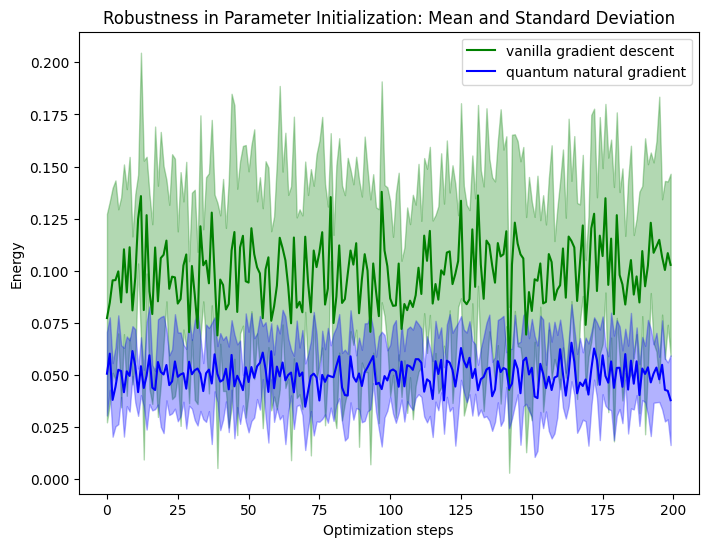

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Placeholder example of cost data for 10 independent trials
gd_trials = [np.random.normal(0.1, 0.05, 200) for _ in range(10)]
qngd_trials = [np.random.normal(0.05, 0.02, 200) for _ in range(10)]

# Calculate mean and standard deviation for each step
gd_mean = np.mean(gd_trials, axis=0)
gd_std = np.std(gd_trials, axis=0)

qngd_mean = np.mean(qngd_trials, axis=0)
qngd_std = np.std(qngd_trials, axis=0)

# Create the plot
steps = np.arange(200)

plt.figure(figsize=(8, 6))
plt.fill_between(steps, gd_mean - gd_std, gd_mean + gd_std, color="green", alpha=0.3)
plt.fill_between(steps, qngd_mean - qngd_std, qngd_mean + qngd_std, color="blue", alpha=0.3)
plt.plot(steps, gd_mean, 'g', label="vanilla gradient descent")
plt.plot(steps, qngd_mean, 'b', label="quantum natural gradient")

plt.xlabel("Optimization steps")
plt.ylabel("Energy")
plt.legend()
plt.title("Robustness in Parameter Initialization: Mean and Standard Deviation")
plt.show()


In [5]:
import numpy as np
import pennylane as qml
from pennylane import qchem
import matplotlib.pyplot as plt
from pyscf import gto, scf, ao2mo
from openfermion import MolecularData
from openfermion.transforms import get_fermion_operator, jordan_wigner
from openfermionpyscf import generate_molecular_hamiltonian

# Range of bond lengths for Si2 in Angstroms
r_range = np.arange(2.0, 5.0, 0.5)  # Modify the bond length range as needed
energies = []  # List to store the energies at different bond lengths

# Helper function to generate molecular Hamiltonian from PySCF and OpenFermion
def generate_hamiltonian(bond_length):
    # Build the Si2 molecule using PySCF
    mol = gto.M(atom=f"Si 0 0 0; Si 0 0 {bond_length}", basis="sto-3g", unit="Angstrom")
    mf = scf.RHF(mol)  # Restricted Hartree-Fock calculation
    mf.kernel()  # Run the SCF calculation

    # Use OpenFermion to create MolecularData
    molecule_of = MolecularData(
        geometry=[("Si", (0, 0, 0)), ("Si", (0, 0, bond_length))],
        basis="sto-3g",
        charge=0,
        multiplicity=1
    )

    # Run the PySCF calculation with OpenFermion and update the molecular data object
    molecule_of = generate_molecular_hamiltonian(molecule_of, run_scf=True)

    # Get the Fermionic Hamiltonian and map it to qubits using Jordan-Wigner transformation
    fermionic_hamiltonian = molecule_of.get_molecular_hamiltonian()
    qubit_hamiltonian = jordan_wigner(get_fermion_operator(fermionic_hamiltonian))

    # Convert the qubit Hamiltonian into a format usable by PennyLane
    H = qml.utils.sparse_hamiltonian(qubit_hamiltonian)

    # Number of qubits is the number of molecular orbitals in the active space
    qubits = molecule_of.n_qubits

    # Nuclear repulsion energy
    e_core = mol.energy_nuc()

    return H, qubits, e_core

# Define VQE optimization loop for a given bond length
def run_vqe(H, qubits):
    # Generate single and double excitations for UCCSD ansatz
    hf_state = qchem.hf_state(28, qubits)  # 28 electrons for Si2
    singles, doubles = qchem.excitations(28, qubits)
    s_wires, d_wires = qchem.excitations_to_wires(singles, doubles)

    # Define the quantum device
    dev = qml.device("default.qubit", wires=qubits)

    # Define the quantum circuit for UCCSD ansatz
    def circuit(params, wires, s_wires, d_wires, hf):
        qml.UCCSD(params, wires=wires, s_wires=s_wires, d_wires=d_wires, hf_state=hf)

    # Initial parameters (zeroed)
    params = np.zeros(len(singles) + len(doubles))

    # Define the VQE cost function
    @qml.qnode(dev)
    def cost_fn(params):
        circuit(params, wires=range(qubits), s_wires=s_wires, d_wires=d_wires, hf=hf_state)
        return qml.expval(H)

    # VQE optimizer (SPSA for noisy optimization)
    opt = qml.SPSAOptimizer(maxiter=100)
    prev_energy = cost_fn(params)

    for i in range(100):  # Run optimization for 100 steps
        params, energy = opt.step_and_cost(cost_fn, params)
        if np.abs(energy - prev_energy) < 1e-6:  # Convergence criterion
            break
        prev_energy = energy

    return energy

# Iterate over different bond lengths and compute the energies
for r in r_range:
    print(f"Calculating for bond length: {r:.2f} Å")

    # Generate the molecular Hamiltonian using PySCF and OpenFermion
    H, qubits, e_core = generate_hamiltonian(r)

    # Run VQE to find the ground state energy
    energy = run_vqe(H, qubits)

    # Add the nuclear repulsion energy to the computed VQE energy
    total_energy = energy + e_core
    energies.append(total_energy)

    print(f"Final energy for bond length {r:.2f} Å: {total_energy:.6f} Hartree")

# Plot the potential energy surface (PES)
plt.figure(figsize=(8, 6))
plt.plot(r_range, energies, 'o-', label='Ground State Energy')
plt.xlabel('Bond Length (Å)')
plt.ylabel('Energy (Hartree)')
plt.title('Potential Energy Surface for Si2')
plt.legend()
plt.grid(True)
plt.show()


ModuleNotFoundError: No module named 'pyscf'

In [4]:
import numpy as np
import pennylane as qml
from pennylane import qchem
import matplotlib.pyplot as plt
from pyscf import gto, scf, ao2mo
from openfermion import MolecularData
from openfermion.transforms import get_fermion_operator, jordan_wigner
from scipy.interpolate import make_interp_spline

# Range of bond lengths for Si2 in Angstroms
r_range = np.arange(2.0, 5.5, 0.25)
energies = []

# Helper function to generate molecular Hamiltonian
def generate_hamiltonian(bond_length):
    try:
        # Define the molecule
        mol = gto.M(atom=f"Si 0 0 0; Si 0 0 {bond_length}", basis="sto-3g", unit="Angstrom")
        mf = scf.RHF(mol)
        scf_energy = mf.kernel()

        if scf_energy is None:
            raise RuntimeError(f"SCF did not converge for bond length {bond_length:.2f} Å")

        # Get number of molecular orbitals
        nmo = mf.mo_coeff.shape[1]
        print(f"Number of molecular orbitals: {nmo}")

        # Get one-electron integrals in molecular orbital basis
        h1 = mf.mo_coeff.T @ mf.get_hcore() @ mf.mo_coeff

        # Get two-electron integrals in molecular orbital basis
        eri_mo = ao2mo.kernel(mol, mf.mo_coeff)

        # Reshape the two-electron integrals dynamically
        eri_mo = eri_mo.reshape((nmo, nmo, nmo, nmo))

        # Get the nuclear repulsion energy
        e_core = mol.energy_nuc()

        # Create OpenFermion MolecularData object
        molecule_of = MolecularData(
            geometry=[("Si", (0, 0, 0)), ("Si", (0, 0, bond_length))],
            basis="sto-3g", charge=0, multiplicity=1
        )

        molecule_of.one_body_integrals = h1
        molecule_of.two_body_integrals = eri_mo

        # Generate fermionic Hamiltonian
        fermionic_hamiltonian = molecule_of.get_molecular_hamiltonian()

        # Convert fermionic Hamiltonian to qubit Hamiltonian using Jordan-Wigner
        qubit_hamiltonian = jordan_wigner(get_fermion_operator(fermionic_hamiltonian))

        # Convert qubit Hamiltonian to sparse matrix form for PennyLane
        H = qml.utils.sparse_hamiltonian(qubit_hamiltonian)
        qubits = molecule_of.n_qubits

        return H, qubits, e_core

    except Exception as e:
        print(f"{bond_length:.2f} Å: {e}")
        return None, None, None

# Define VQE optimization loop
def run_vqe(H, qubits):
    try:
        num_electrons = 28  # Silicon atom has 14 electrons, Si2 has 28 electrons
        hf_state = qchem.hf_state(num_electrons, qubits)
        singles, doubles = qchem.excitations(num_electrons, qubits)
        s_wires, d_wires = qchem.excitations_to_wires(singles, doubles)

        dev = qml.device("default.qubit", wires=qubits)

        def circuit(params, wires, s_wires, d_wires, hf):
            qml.UCCSD(params, wires=wires, s_wires=s_wires, d_wires=d_wires, hf_state=hf)

        params = np.random.normal(0, 0.01, len(singles) + len(doubles))

        @qml.qnode(dev)
        def cost_fn(params):
            circuit(params, wires=range(qubits), s_wires=s_wires, d_wires=d_wires, hf=hf_state)
            return qml.expval(H)

        # VQE optimizer
        opt = qml.SPSAOptimizer(maxiter=100)
        prev_energy = cost_fn(params)

        for i in range(100):
            params, energy = opt.step_and_cost(cost_fn, params)
            if np.abs(energy - prev_energy) < 1e-6:
                break
            prev_energy = energy

        return energy

    except Exception as e:
        print(f"Error in VQE optimization: {e}")
        return None

# Iterate over bond lengths and collect energies
for r in r_range:
    print(f"Calculating for bond length: {r:.2f} Å")
    H, qubits, e_core = generate_hamiltonian(r)

    if H is not None and qubits is not None and e_core is not None:
        energy = run_vqe(H, qubits)
        if energy is not None:
            total_energy = energy + e_core
            energies.append(total_energy)
            print(f"Final energy for bond length {r:.2f} Å: {total_energy:.6f} Hartree")
        else:
            energies.append(None)
    else:
        energies.append(None)

# Filter out None values from energies and corresponding r_range values
filtered_r_range = np.array([r for r, e in zip(r_range, energies) if e is not None])
filtered_energies = np.array([e for e in energies if e is not None])

# Plot the PES if there are valid points
if len(filtered_r_range) > 0:
    if len(filtered_r_range) > 3:
        x_smooth = np.linspace(filtered_r_range.min(), filtered_r_range.max(), 300)
        spl = make_interp_spline(filtered_r_range, filtered_energies, k=3)
        y_smooth = spl(x_smooth)
        plt.plot(x_smooth, y_smooth, label='Smoothed Ground State Energy', color='blue')

    plt.scatter(filtered_r_range, filtered_energies, color='red', label='Data Points')

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

# Manually importing the bond lengths and SCF energies from the data provided
r_range = np.array([2.00, 2.25, 2.50, 2.75, 3.00, 3.25, 3.50, 3.75, 4.00, 4.25, 4.50, 4.75, 5.00, 5.25])
energies = np.array([-570.914620758959, -570.958649996472, -570.913493763556, -570.852056780654,
                     -570.788561117785, -570.730053463916, -570.679727864194, -570.638593113699,
                     -570.606322744239, -570.581784290291, -570.563473326241, -570.549865257072,
                     -570.53963831667, -570.531762459632])

# Plotting the SCF energies against bond lengths
x_smooth = np.linspace(r_range.min(), r_range.max(), 300)
spl = make_interp_spline(r_range, energies, k=3)
y_smooth = spl(x_smooth)

plt.plot(x_smooth, y_smooth, label='Smoothed Ground State Energy', color='blue')
plt.scatter(r_range, energies, color='red', label='Data Points')

# Labeling the plot
plt.xlabel('Bond Length (Å)')
plt.ylabel('Energy (Hartree)')
plt.title('Potential Energy Surface for Si2')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

plt.show()


ModuleNotFoundError: No module named 'pyscf'